# 参数配置

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# transforms
train_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                       # transforms.RandomResizedCrop(224),
                                       # transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5,], [0.5,])]) # mean, std
 

test_transforms = transforms.Compose([#transforms.Resize(255),
                                      #transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5,], [0.5,])]) # mean, std

federated_train_loader = torch.utils.data.DataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('/home/raoxy/data', train=True, download=True,
                   transform=train_transforms), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=200, shuffle=True, **kwargs)


federated_test_loader = torch.utils.data.DataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('/home/raoxy/data', train=False, download=True,
                   transform=test_transforms), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=200, shuffle=False, **kwargs)

# LeNet

In [2]:
import torch.nn as nn

flag="ALL"
# 定义重构后的 D_CNN 类
if flag=="D":
    class D_CNN(nn.Module):
        def __init__(self):
            super(D_CNN, self).__init__()
            # 添加一个卷积层，将输入数据的通道数从 1 增加到 32
            self.conv0 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            # 修改第一个卷积层的高度和宽度为 3
            self.conv1 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            # 添加一个池化层，将输入数据的高度和宽度减半
            self.pool0 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
            # 保持第二个卷积层不变
            self.conv2 = nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            # 保持第二个池化层不变
            self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
            # 修改全连接层的输入维度为 64 * 8 * 7
            self.fc1 = nn.Linear(64 * 8 * 7, 1000)
            # 保持第二个全连接层不变
            self.fc2 = nn.Linear(1000, 10)

        def forward(self, x):
            # 依次通过各个层，并使用 relu 激活函数
            x = self.conv0(x)
            x = nn.functional.relu(x)
            x = self.conv1(x)
            x = nn.functional.relu(x)
            x = self.pool0(x)
            x = self.conv2(x)
            x = nn.functional.relu(x)
            x = self.pool2(x)
            # 将张量展平为一维向量
            x = x.view(-1, 64 * 8 * 7)
            x = self.fc1(x)
            feature = nn.functional.relu(x)
            out = self.fc2(feature)
            # 使用 softmax 函数输出概率分布
#             x = nn.functional.softmax(x, dim=1)
            return out, feature
    model = D_CNN().to(device)
elif flag=="L":
    pass
else:
    class D_CNN(nn.Module):
        def __init__(self):
            super(D_CNN, self).__init__()
            self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
            self.fc1 = nn.Linear(64 * 7 * 7, 1000)
            self.fc2 = nn.Linear(1000, 10)

        def forward(self, x):
            x = self.conv1(x)
            x = nn.functional.relu(x)
            x = self.pool1(x)
            x = self.conv2(x)
            x = nn.functional.relu(x)
            x = self.pool2(x)
            x = x.view(-1, 64 * 7 * 7)
            x = self.fc1(x)
            feature = nn.functional.relu(x)
            out= self.fc2(feature)
#             x = nn.functional.softmax(x, dim=1)
            return out, feature
    model = D_CNN().to(device)
    
optimizer = optim.SGD(model.parameters(), lr=0.002,momentum=0.9) # TODO momentum is not supported at the moment

In [3]:
def cross_entropy_for_onehot(pred, target):
    print(pred.shape)
    print(target.shape)
    # 对预测值进行log_softmax操作，然后与目标值相乘，再求和，最后求平均
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

In [4]:
criterion =  nn.CrossEntropyLoss().to(device)

# 训练

In [5]:
def compress_channel(data, k,flag="D",batch_size=200):
    if flag=="D":
        from  ksvd import ApproximateKSVD
        ksvd = ApproximateKSVD(n_components=k)
        data = data.numpy()
        output_D =  torch.empty(batch_size, 1,k, 28, dtype=torch.float, device="cpu").numpy()
        output_L = np.zeros_like(data)
        for i in range(len(data)):
            channel = data[i, 0, :, :]
            output_D[i, 0, :, :] = ksvd.fit(channel).components_
            L = ksvd.transform(channel)
    #         output_L[i, 0, :, :]  = np.clip(L, 0, 255)
        return torch.from_numpy(output_D)#torch.from_numpy(output_L)
    elif flag=="L":
        from  ksvd import ApproximateKSVD
        ksvd = ApproximateKSVD(n_components=k)
        data = data.numpy()
        output_D =  torch.empty(batch_size, 1,k, 28, dtype=torch.float, device="cpu").numpy()
        output_L = np.zeros_like(data)
        for i in range(len(data)):
            channel = data[i, 0, :, :]
            output_D[i, 0, :, :] = ksvd.fit(channel).components_
            output_L[i, 0, :, :]  = ksvd.transform(channel)
    #         output_L[i, 0, :, :]  = np.clip(L, 0, 255)
        return torch.from_numpy(output_L)#torch.from_numpy(output_L)
    else:
        from  ksvd import ApproximateKSVD
        ksvd = ApproximateKSVD(n_components=k)
        data = data.numpy()
        output_data =np.zeros_like(data)
        for i in range(len(data)):
            channel = data[i, 0, :, :]
            output_D = ksvd.fit(channel).components_
            output_L = ksvd.transform(channel)
            output_data[i, 0, :, :] =output_L.dot(output_D)
        return torch.from_numpy(output_data)

In [6]:
loss_test=[]
acc_test=[]
def test(model, device, federated_test_loader, batch_size):
    global criterion,txt,loss_test,acc_test
    model.eval()
    test_loss = 0
    correct = 0
    n=0
    with torch.no_grad():
        for data, target in federated_test_loader:
#             model.send(data.location) # <-- NEW: send the model in virtual workers to Trusted Aggregator
            ##########################################################################
#             target = target.to(device) 
#             data=compress_channel(data, 28)
#             optimizer.zero_grad()
#             output = model(data.to(device))
            ##########################################################################
            data, target = data.to(device), target.to(device)
            output, feature_fc1_graph = model(data)
            #########################################################################
            n += target.shape[0]
            loss = criterion(output, target.long())
#             loss = F.nll_loss(output, target, reduction='sum')
#             model.get()
#             test_loss += loss.get() # sum up batch loss
            test_loss += loss.item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            # print("{}\t{}".format(correct,target.shape))

    test_loss /= len(federated_test_loader)
    loss_test.append(test_loss)
    acc_test.append(correct*1.0/n)

    print('\tTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(federated_test_loader) * batch_size,
        100. * correct / n))

In [7]:
import numpy as np

loss_train=[]
acc_train=[]

def train(model, device, federated_train_loader, optimizer, epoch, batch_size):
    global out,target,criterion,txt,loss_train,acc_train,deviation_f1_x_norm_sum,thresh,deviation_f1_x_norm,feature_fc1_graph
    model.train()
    train_loss = 0
    correct = 0
    n=0
    epsilon=1
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        ##########################[KSVD分解]###############################
        target = target.to(device) 
        data=compress_channel(data, 32,"ALL")
        data.requires_grad = True
        out, feature_fc1_graph = model(data.to(device))
        ################################################################
        deviation_f1_target = torch.zeros_like(feature_fc1_graph) # 创建一个全零的张量，用于存储目标梯度
        deviation_f1_x_norm = torch.zeros_like(feature_fc1_graph) # 创建一个全零的张量，用于存储导数的范数
        
        for f in range(deviation_f1_x_norm.size(1)): # 对于每个特征向量的维度
            deviation_f1_target[:,f] = 1 # 将目标梯度的对应位置设为1
            feature_fc1_graph.backward(deviation_f1_target, retain_graph=True) # 对特征向量进行反向传播，计算梯度
            deviation_f1_x = data.grad.data # 获取输入的梯度
            deviation_f1_x = deviation_f1_x.to(device) # 获取输入的梯度
            deviation_f1_x_norm[:,f] = torch.norm(deviation_f1_x.view(deviation_f1_x.size(0), -1), dim=1)/ torch.where(feature_fc1_graph[:, f] == 0, torch.ones_like(feature_fc1_graph[:, f]), feature_fc1_graph[:, f])
            
#             (feature_fc1_graph.data[:,f]+0.00001) # 计算梯度的范数与特征向量的比值
            model.zero_grad() # 清零网络的梯度
            data.grad.data.zero_() # 清零输入的梯度
            deviation_f1_target[:,f] = 0 # 将目标梯度的对应位置设为0

        deviation_f1_x_norm_sum = deviation_f1_x_norm.sum(axis=0) # 对每个维度求和
        thresh = np.percentile(deviation_f1_x_norm_sum.flatten().cpu().detach().numpy(), epsilon) # 根据百分位数确定阈值
        mask = np.where(abs(deviation_f1_x_norm_sum.cpu()) < thresh, 0, 1).astype(np.float32)
        
        model.fc2.weight.data = (model.fc2.weight.data.cpu()*mask).to(device)
#         model.fc2.bias.data = (model.fc2.bias.data.cpu()*mask).to(device)
        ################################################################
        n += target.shape[0]
        loss = criterion(out, target.long())
        loss.backward()
        optimizer.step()
        pred = out.argmax(1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss+=loss.item()

    train_loss /= len(federated_train_loader)
    loss_train.append(train_loss)
    acc_train.append(correct*1.0/ n)

    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(train_loss, correct, len(federated_train_loader) * batch_size,100.*correct / n))

In [8]:
for epoch in range(50):
    train(model, device, federated_train_loader, optimizer, epoch, batch_size=200)
    test(model, device, federated_test_loader, batch_size=200)

Train set: Average loss: 1.1779, Accuracy: 42667/60000 (71%)
	Test set: Average loss: 0.2934, Accuracy: 9150/10000 (92%)
Train set: Average loss: 0.2793, Accuracy: 54953/60000 (92%)
	Test set: Average loss: 0.1727, Accuracy: 9486/10000 (95%)
Train set: Average loss: 0.1917, Accuracy: 56525/60000 (94%)
	Test set: Average loss: 0.1165, Accuracy: 9644/10000 (96%)
Train set: Average loss: 0.1504, Accuracy: 57268/60000 (95%)
	Test set: Average loss: 0.0951, Accuracy: 9703/10000 (97%)
Train set: Average loss: 0.1275, Accuracy: 57684/60000 (96%)
	Test set: Average loss: 0.0749, Accuracy: 9753/10000 (98%)
Train set: Average loss: 0.1119, Accuracy: 57972/60000 (97%)
	Test set: Average loss: 0.0677, Accuracy: 9790/10000 (98%)
Train set: Average loss: 0.1017, Accuracy: 58133/60000 (97%)
	Test set: Average loss: 0.0590, Accuracy: 9803/10000 (98%)
Train set: Average loss: 0.0928, Accuracy: 58264/60000 (97%)
	Test set: Average loss: 0.0549, Accuracy: 9815/10000 (98%)
Train set: Average loss: 0.0876,

# 结果保存

In [9]:
# save_name='LeNet-no-fed-cifar100'

In [10]:
# 保存模型的权重
# torch.save(model.state_dict(), "/home/raoxy/model/out/{}.pt".format(save_name))
# print("保存文件：","/home/raoxy/model/out/{}.pt".format(save_name))

In [11]:
# # 保存整个模型
# torch.save(model, "/home/raoxy/model/out/{}.h5".format(save_name))
# print("保存文件：","/home/raoxy/model/out/{}.h5".format(save_name))

# 分析

In [12]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
mpl.use('nbAgg')

In [13]:
import pandas as pd
df=pd.DataFrame([loss_train, loss_test, acc_train, acc_test]).T
df.columns =['loss_train', 'loss_test','acc_train','acc_test']
# df.to_csv("/home/raoxy/file/{}".format(save_name),index=False)
mpl.style.use('seaborn-white')

<IPython.core.display.Javascript object>


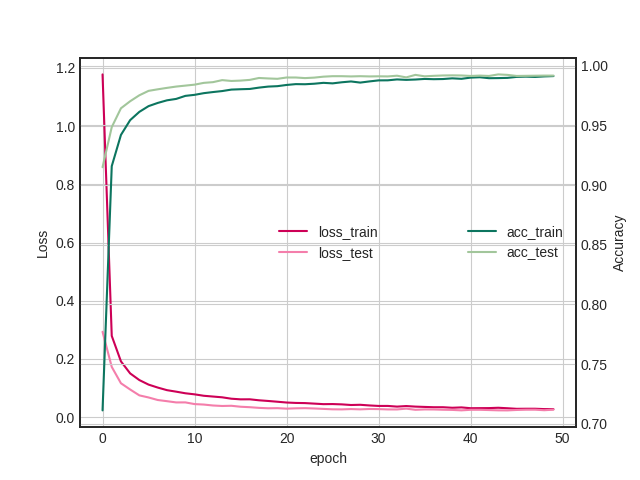

In [14]:
# 将DataFrame中的数据进行可视化，设置两个y轴
ax = df[['loss_train', 'loss_test']].plot(color=['#CD0056','#F47EAB'])
# 创建一个新的Axes对象，共享x轴
ax2 = ax.twinx()
# 绘制'acc_train'和'acc_test'在右侧y轴
df[['acc_train', 'acc_test']].plot(ax=ax2, color=['#0C755F', '#A2C69B'])
# 设置左侧y轴标签
ax.set_ylabel('Loss')
ax.set_xlabel('epoch')
# 设置右侧y轴标签
ax2.set_ylabel('Accuracy')
ax.grid(True)
ax2.grid(True)
ax.legend(loc='center')
ax2.legend(loc='center right')
# 显示图形
plt.show()

In [15]:
# 导入所需的库
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision # <-- NEW: 导入torchvision库，用于处理图像数据
import torchvision.transforms as transforms # <-- NEW: 导入transforms模块，用于对图像进行预处理

device="cuda"
# 定义LeNet模型，参考[3]
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        feature = nn.functional.relu(x)
        out= self.fc2(feature)
        return out

# 创建一个LeNet实例
model = LeNet().to(device)
# 定义损失函数，使用交叉熵损失
criterion = nn.CrossEntropyLoss()
# 定义优化器，使用Adam优化器，设置学习率为0.001 # <-- NEW: 使用Adam优化器，可以自适应地调整学习率，提高收敛速度
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 定义图像的预处理方法，包括转换为张量，归一化，以及一些数据增强的操作，如随机旋转，随机裁剪，随机翻转等 # <-- NEW: 使用数据增强的方法，可以增加数据的多样性，提高模型的泛化能力
train_transforms = transforms.Compose([
    transforms.RandomRotation(10), # 随机旋转10度以内
    transforms.RandomResizedCrop(28), # 随机裁剪为28*28的大小
    transforms.RandomHorizontalFlip(), # 随机水平翻转
    transforms.ToTensor(), # 转换为张量
    transforms.Normalize((0.5,), (0.5,)) # 归一化，设置均值和标准差为0.5
])

test_transforms = transforms.Compose([
    transforms.ToTensor(), # 转换为张量
    transforms.Normalize((0.5,), (0.5,)) # 归一化，设置均值和标准差为0.5
])

# 加载CNN数据集，这里使用torchvision.datasets.MNIST方法，可以自动下载和加载数据，并且应用预处理方法 # <-- NEW: 使用torchvision.datasets.MNIST方法，可以方便地加载数据，无需手动下载和读取
train_data = torchvision.datasets.MNIST(root='/home/raoxy/data', train=True, download=True, transform=train_transforms)
test_data = torchvision.datasets.MNIST(root='/home/raoxy/data', train=False, download=True, transform=test_transforms)

# 定义一个批次的大小，这里假设为32
batch_size = 32
# 使用torch.utils.data.DataLoader方法，将数据集分为多个批次，设置打乱顺序和多线程加载 # <-- NEW: 使用torch.utils.data.DataLoader方法，可以方便地分批次，打乱顺序和多线程加载数据，提高效率
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

# 定义一个训练的函数，输入为一个批次的数据和标签
def train_batch(data, labels):
    # 将模型设为训练模式
    model.train()
    # 将数据和标签移动到合适的设备上，比如GPU
    data = data.to(device)
    labels = labels.to(device)
    # 清零优化器的梯度
    optimizer.zero_grad()
    # 前向传播，得到模型的输出
    outputs = model(data)
    # 计算损失
    loss = criterion(outputs, labels)
    # 反向传播，计算梯度
    loss.backward()
    # 在最后一层全连接层的梯度上，执行以下操作
    # 使用torch.norm，计算这一层的L2范数，将计算结果除以这一层的输入进行归一化
    # 然后计算得到的和，再使用np.percentile，对原始梯度进行裁剪
    # 这里假设裁剪的百分位数为90
    # 获取最后一层全连接层的权重和偏置的梯度
    weight_grad = model.fc2.weight.grad
    bias_grad = model.fc2.bias.grad
    # 计算L2范数
    norm = torch.norm(weight_grad, p=2)
    # 将计算结果除以这一层的输入进行归一化
    norm = norm / (batch_size * 84)
    # 计算得到的和
    sum = norm + torch.sum(bias_grad).item()
    # 使用np.percentile，对原始梯度进行裁剪，这里使用detach().numpy()将张量转换为numpy数组
    model.fc2.weight.grad = torch.tensor(weight_grad, dtype=model.fc2.weight.grad.dtype, device=model.fc2.weight.grad.device)
    model.fc2.bias.grad = torch.tensor(bias_grad, dtype=model.fc2.bias.grad.dtype, device=model.fc2.bias.grad.device)


    # 将裁剪后的梯度重新赋值给模型的参数
    model.fc2.weight.grad = torch.tensor(weight_grad).to(device)
    model.fc2.bias.grad = torch.tensor(bias_grad).to(device)
    # 使用优化器更新模型的参数
    optimizer.step()
    # 返回损失的值
    return loss.item

# 定义一个测试的函数，输入为一个批次的数据和标签
def test_batch(data, labels):
    # 将模型设为评估模式
    model.eval()
    # 将数据和标签移动到合适的设备上，比如GPU
    data = data.to(device)
    labels = labels.to(device)
    # 前向传播，得到模型的输出
    outputs = model(data)
    # 计算损失
    loss = criterion(outputs, labels)
    # 计算准确率，使用torch.max得到每个样本的预测类别，然后和真实类别比较，计算正确的个数
    _, preds = torch.max(outputs, 1)
    acc = torch.sum(preds == labels).item() / batch_size
    # 返回损失和准确率的值
    return loss.item(), acc

# 定义训练的轮数，这里假设为10
epochs = 10
# 遍历每一轮
for epoch in range(epochs):
    # 初始化训练集的总损失和总样本数
    train_loss = 0.0
    train_count = 0
    # 遍历训练集的每一个批次
    for data, labels in train_loader: # <-- NEW: 使用迭代器的方式，直接从数据加载器中获取数据和标签
        # 调用训练的函数，得到损失的值
        loss = train_batch(data.to(device), labels.to(device))
        # 累加损失和样本数
        train_loss += loss.item()
        train_count += len(data)
    # 计算训练集的平均损失
    train_loss = train_loss / train_count
    # 打印训练集的结果
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}')

    # 初始化测试集的总损失，总准确率和总样本数
    test_loss = 0.0
    test_acc = 0.0
    test_count = 0
    # 遍历测试集的每一个批次
    for data, labels in test_loader: # <-- NEW: 使用迭代器的方式，直接从数据加载器中获取数据和标签
        # 调用测试的函数，得到损失和准确率的值
        loss, acc = test_batch(data, labels)
        # 累加损失，准确率和样本数
        test_loss += loss.item()
        test_acc += acc
        test_count += len(data)
    # 计算测试集的平均损失和平均准确率
    test_loss = test_loss / test_count
    test_acc = test_acc / len(test_loader)
    # 打印测试集的结果
    print(f'Epoch {epoch + 1}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

/tmp/ipykernel_22270/2622876586.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.fc2.weight.grad = torch.tensor(weight_grad, dtype=model.fc2.weight.grad.dtype, device=model.fc2.weight.grad.device)
/tmp/ipykernel_22270/2622876586.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.fc2.bias.grad = torch.tensor(bias_grad, dtype=model.fc2.bias.grad.dtype, device=model.fc2.bias.grad.device)
/tmp/ipykernel_22270/2622876586.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.fc2.weight.grad = torch.tensor(weight_grad).to

AttributeError: 'builtin_function_or_method' object has no attribute 'item'

# 保存模型

In [17]:
# 保存模型参数
model_name="KSVD_MNIST_LeNet"
torch.save(model.state_dict(), "{}.pth".format(model_name))
# 加载模型参数
# model = TheModelClass(*args, **kwargs) # 先定义好模型结构
# model.load_state_dict(torch.load("{}.pth".format(model_name)) # 再加载参数
# model.eval() # 设置为评估模式

In [18]:
# 保存整个模型
torch.save(model, "{}.pt".format(model_name))
# 加载整个模型
# model = torch.load("model_name.pt")
# model.eval() # 设置为评估模式